In [6]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.4 MB/s eta 0:00:00


In [14]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Tuple, Dict
from gymnasium.wrappers import RecordVideo

In [15]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Tuple, Dict
from gymnasium.wrappers import RecordVideo
import seaborn as sns

class CartPoleQLearningAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float = 0.1,
        discount_factor: float = 0.95,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay: float = 0.995,
        n_bins: int = 10
    ):
        """
        Input: Environment and learning parameters
        Output: Initialized Q-learning agent
        Function: Creates a Q-learning agent with specified parameters for CartPole
        """
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.n_bins = n_bins
        self.bins = self._create_bins()
        self.q_table = defaultdict(lambda: np.random.uniform(0, 1, env.action_space.n))

    def _create_bins(self) -> Dict[int, np.ndarray]:
        """
        Input: None
        Output: Dictionary of binned spaces for each state dimension
        Function: Creates discretized bins for continuous state space
        """
        bins = {
            0: np.linspace(-4.8, 4.8, self.n_bins),    # Cart Position
            1: np.linspace(-4, 4, self.n_bins),        # Cart Velocity
            2: np.linspace(-0.418, 0.418, self.n_bins),# Pole Angle
            3: np.linspace(-4, 4, self.n_bins)         # Pole Angular Velocity
        }
        return bins

    def discretize_state(self, state: np.ndarray) -> Tuple:
        """
        Input: Continuous state array
        Output: Discretized state tuple
        Function: Converts continuous state values into discrete bin indices
        """
        discretized = []
        for i, value in enumerate(state):
            bin_index = np.digitize(value, self.bins[i]) - 1
            discretized.append(bin_index)
        return tuple(discretized)

    def get_action(self, state: np.ndarray) -> int:
        """
        Input: Current state
        Output: Selected action
        Function: Chooses action using epsilon-greedy strategy
        """
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        discretized_state = self.discretize_state(state)
        return int(np.argmax(self.q_table[discretized_state]))

    def update(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool):
        """
        Input: Current state, action, reward, next state, and done flag
        Output: None
        Function: Updates Q-values using Q-learning update rule
        """
        current_state = self.discretize_state(state)
        next_state = self.discretize_state(next_state)

        future_q_value = (not done) * np.max(self.q_table[next_state])
        temporal_difference = (
            reward + self.gamma * future_q_value - self.q_table[current_state][action]
        )

        self.q_table[current_state][action] += self.lr * temporal_difference

    def decay_epsilon(self):
        """
        Input: None
        Output: None
        Function: Decays exploration rate according to epsilon decay schedule
        """
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

In [16]:
def train_agent(n_episodes: int = 1000, render_freq: int = 100) -> Tuple[CartPoleQLearningAgent, list]:
    """
    Input: Number of episodes and rendering frequency
    Output: Trained agent and list of episode rewards
    Function: Trains the Q-learning agent on CartPole environment
    """
    env = gym.make('CartPole-v1')
    env = gym.wrappers.RecordEpisodeStatistics(env)

    agent = CartPoleQLearningAgent(env)
    episode_rewards = []
    epsilon_values = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.update(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

        agent.decay_epsilon()
        episode_rewards.append(episode_reward)
        epsilon_values.append(agent.epsilon)

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}, Average Reward (last 100): {avg_reward:.2f}")

    env.close()
    return agent, episode_rewards, epsilon_values

In [17]:
def evaluate_agent(agent: CartPoleQLearningAgent, n_episodes: int = 5, render: bool = True, videos_to_record: int = 1) -> float:
    """
    Input: Trained agent, number of episodes, rendering flag, and number of videos to record
    Output: Mean reward over evaluation episodes
    Function: Evaluates trained agent's performance and records specified number of videos
    """
    env = gym.make('CartPole-v1', render_mode='rgb_array' if render else None)
    if render:
        episode_trigger = lambda x: x < videos_to_record
        env = RecordVideo(env, 'videos2', name_prefix='cartpole-qlearning', episode_trigger=episode_trigger)

    total_rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            episode_reward += reward

        total_rewards.append(episode_reward)

    env.close()
    return np.mean(total_rewards)

Episode 100, Average Reward (last 100): 24.55
Episode 200, Average Reward (last 100): 25.50
Episode 300, Average Reward (last 100): 28.60
Episode 400, Average Reward (last 100): 41.93
Episode 500, Average Reward (last 100): 52.84
Episode 600, Average Reward (last 100): 79.49
Episode 700, Average Reward (last 100): 77.84
Episode 800, Average Reward (last 100): 65.69
Episode 900, Average Reward (last 100): 83.73
Episode 1000, Average Reward (last 100): 99.47


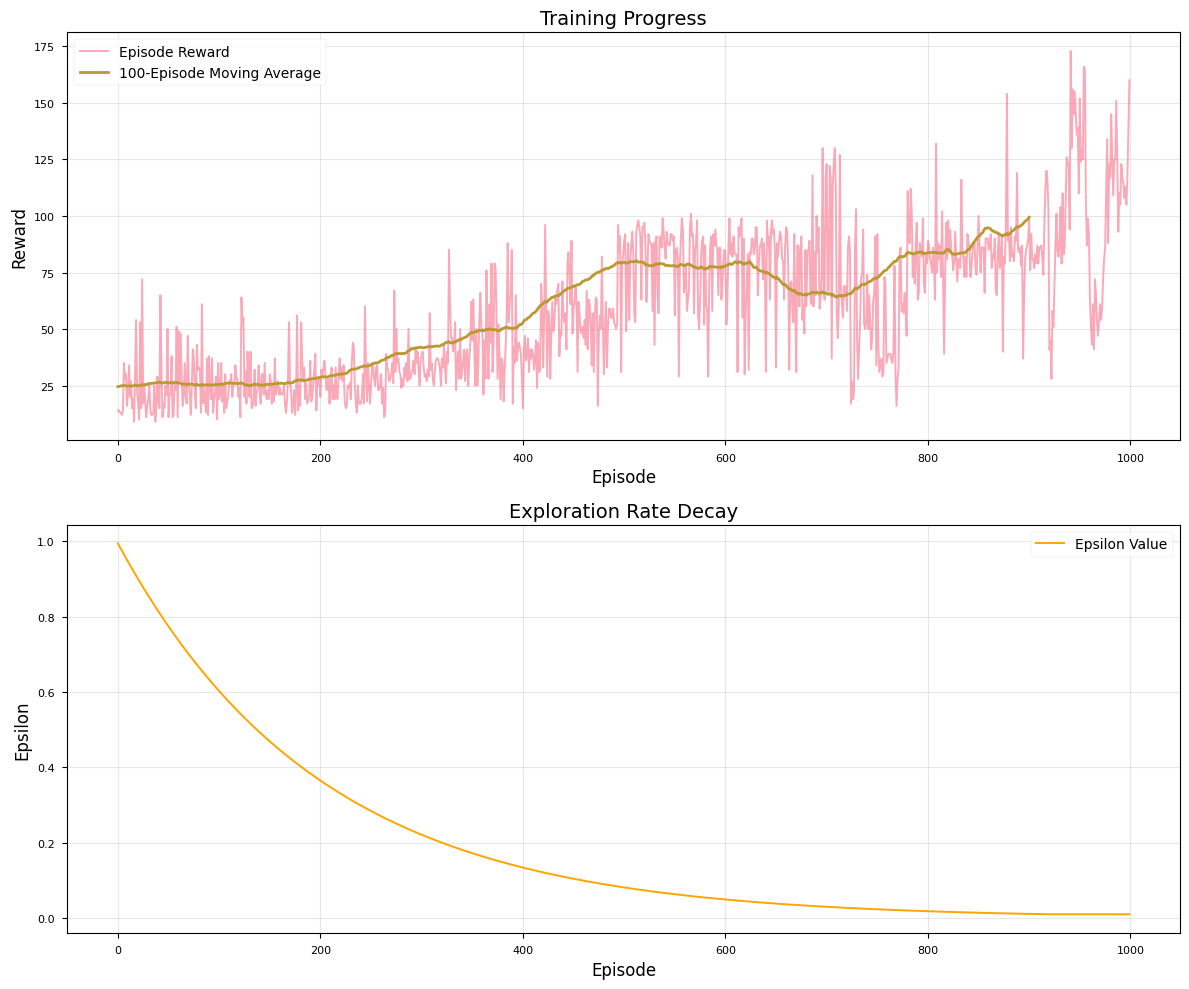

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



Evaluation Results:
Mean reward over 5 episodes: 117.40


In [18]:
if __name__ == "__main__":
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-paper')
    sns.set_palette("husl")

    # Train the agent and collect metrics
    trained_agent, rewards, epsilons = train_agent(n_episodes=1000)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot training rewards
    ax1.plot(rewards, label='Episode Reward', alpha=0.6)
    ax1.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'),
             label='100-Episode Moving Average', linewidth=2)
    ax1.set_title('Training Progress', fontsize=14)
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Reward', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot epsilon decay
    ax2.plot(epsilons, label='Epsilon Value', color='orange')
    ax2.set_title('Exploration Rate Decay', fontsize=14)
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Epsilon', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Evaluate agent
    mean_reward = evaluate_agent(trained_agent, n_episodes=5, render=True, videos_to_record=1)
    print(f"\nEvaluation Results:")
    print(f"Mean reward over 5 episodes: {mean_reward:.2f}")